# MediMine: Association Rule Mining (Apriori)
**Author:** Hussam M. Bansao
**Goal:** Generate and visualize strong association rules between symptoms and diseases.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules

# Settings for nice plots
plt.style.use('ggplot')

## 1. Load Processed Data
Load the One-Hot Encoded data we created in the previous notebook.

In [2]:
try:
    df_encoded = pd.read_csv('../data/processed/encoded_symptoms.csv')
    print("✅ Processed data loaded.")
except FileNotFoundError:
    print("❌ Error: Processed data not found. Run '01_Data_Preprocessing.ipynb' first.")

✅ Processed data loaded.


## 2. Run Apriori Algorithm
We look for itemsets with a minimum support of 3% (0.03).

In [3]:
frequent_itemsets = apriori(df_encoded, min_support=0.03, use_colnames=True, max_len=4, low_memory=True)

print(f"Found {len(frequent_itemsets)} frequent itemsets.")
display(frequent_itemsets.sort_values(by='support', ascending=False).head())

Found 1073 frequent itemsets.


,support,itemsets
19,0.392683,(fatigue)
47,0.389024,(vomiting)
21,0.276829,(high fever)
27,0.234146,(loss of appetite)
34,0.232927,(nausea)


## 3. Generate Association Rules
We generate rules with a minimum confidence of 70%, then filter for **Lift > 1.2** to ensure positive correlation.

In [4]:
# Generate Rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Filter for meaningful rules (Lift > 2.0)
strong_rules = rules[rules['lift'] > 2.0].sort_values(by='lift', ascending=False)

print(f"Found {len(strong_rules)} strong association rules.")
display(strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# Save rules to CSV
strong_rules.to_csv('../results/rules.csv', index=False)
print("✅ Rules saved to '../results/rules.csv'")

# 1. Let's see the distribution of diseases found in the "Consequents"
# This converts the frozen sets to strings so we can count them
disease_counts = strong_rules['consequents'].apply(lambda x: list(x)[0]).value_counts()

print("Top 10 Diseases Identified by Rules:")
print(disease_counts.head(10))

print("\n--------------------------------\n")

# 2. Let's look at rules that are NOT 'Abnormal Menstruation'
# We filter out the menstruation rules to see what's underneath
mask = strong_rules['consequents'].apply(lambda x: 'abnormal menstruation' not in str(x))
other_rules = strong_rules[mask]

print(f"Found {len(other_rules)} rules for other diseases.")
display(other_rules[['antecedents', 'consequents', 'lift', 'confidence']].head(10))

Found 2685 strong association rules.


,antecedents,consequents,support,confidence,lift
986,"(abnormal menstruation, irritability)","(fatigue, mood swings)",0.042683,0.875,20.5
149,(mood swings),"(abnormal menstruation, irritability)",0.046341,1.000,20.5
141,"(fatigue, mood swings)",(abnormal menstruation),0.042683,1.000,20.5
143,(abnormal menstruation),"(fatigue, mood swings)",0.042683,0.875,20.5
988,(abnormal menstruation),"(fatigue, mood swings, irritability)",0.042683,0.875,20.5
984,"(fatigue, mood swings)","(abnormal menstruation, irritability)",0.042683,1.000,20.5
146,"(abnormal menstruation, irritability)",(mood swings),0.046341,0.950,20.5
147,"(mood swings, irritability)",(abnormal menstruation),0.046341,1.000,20.5
148,(abnormal menstruation),"(mood swings, irritability)",0.046341,0.950,20.5
981,"(fatigue, mood swings, irritability)",(abnormal menstruation),0.042683,1.000,20.5


✅ Rules saved to '../results/rules.csv'
Top 10 Diseases Identified by Rules:
consequents
fatigue             377
malaise             306
loss of appetite    283
high fever          227
chills              193
vomiting            172
chest pain          126
nausea              115
yellowish skin      105
phlegm               99
Name: count, dtype: int64

--------------------------------

Found 2676 rules for other diseases.


,antecedents,consequents,lift,confidence
986,"(abnormal menstruation, irritability)","(fatigue, mood swings)",20.500000,0.875000
143,(abnormal menstruation),"(fatigue, mood swings)",20.500000,0.875000
988,(abnormal menstruation),"(fatigue, mood swings, irritability)",20.500000,0.875000
146,"(abnormal menstruation, irritability)",(mood swings),20.500000,0.950000
148,(abnormal menstruation),"(mood swings, irritability)",20.500000,0.950000
6,(abnormal menstruation),(mood swings),20.500000,0.950000
534,"(loss of appetite, headache)",(red spots over body),20.472335,0.973684
2699,"(loss of appetite, swelled lymph nodes)","(malaise, mild fever)",20.472335,0.973684
2700,"(malaise, mild fever)","(loss of appetite, swelled lymph nodes)",20.472335,0.948718
537,(red spots over body),"(loss of appetite, headache)",20.472335,0.948718


## 4. Visualization 1: Support vs. Confidence
A scatterplot to view the distribution of our rules.

✅ Scatterplot saved to '../results/visualization.png'


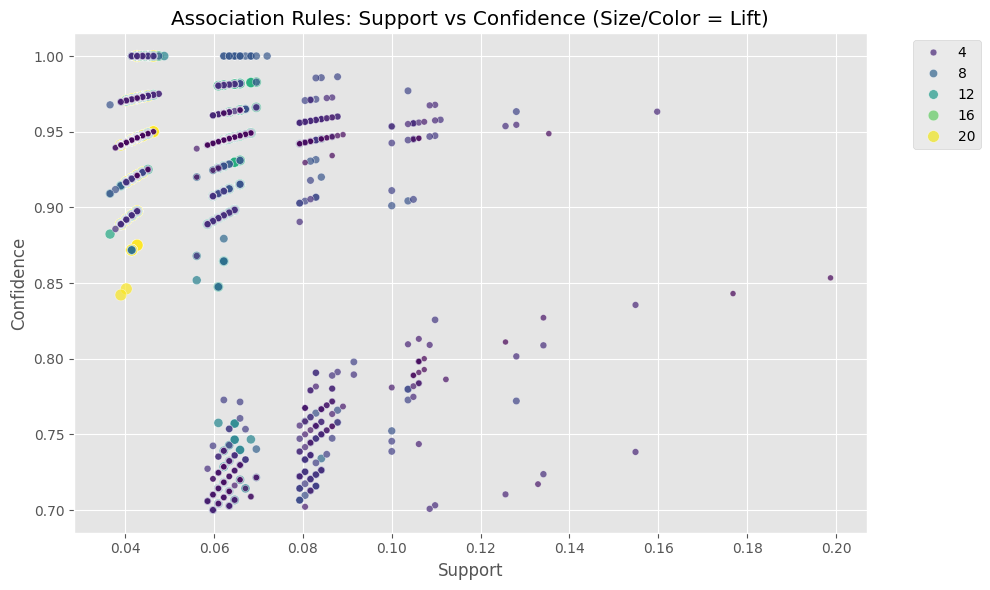

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=strong_rules, 
    x="support", 
    y="confidence", 
    size="lift", 
    hue="lift", 
    palette="viridis", 
    alpha=0.7
)
plt.title("Association Rules: Support vs Confidence (Size/Color = Lift)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('../results/visualization.png', dpi=300, bbox_inches='tight')
print("✅ Scatterplot saved to '../results/visualization.png'")

plt.show()

## 5. Visualization 2: Network Graph
A network graph showing how symptoms cluster around diseases.

✅ Network graph saved to '../results/network_graph.png'


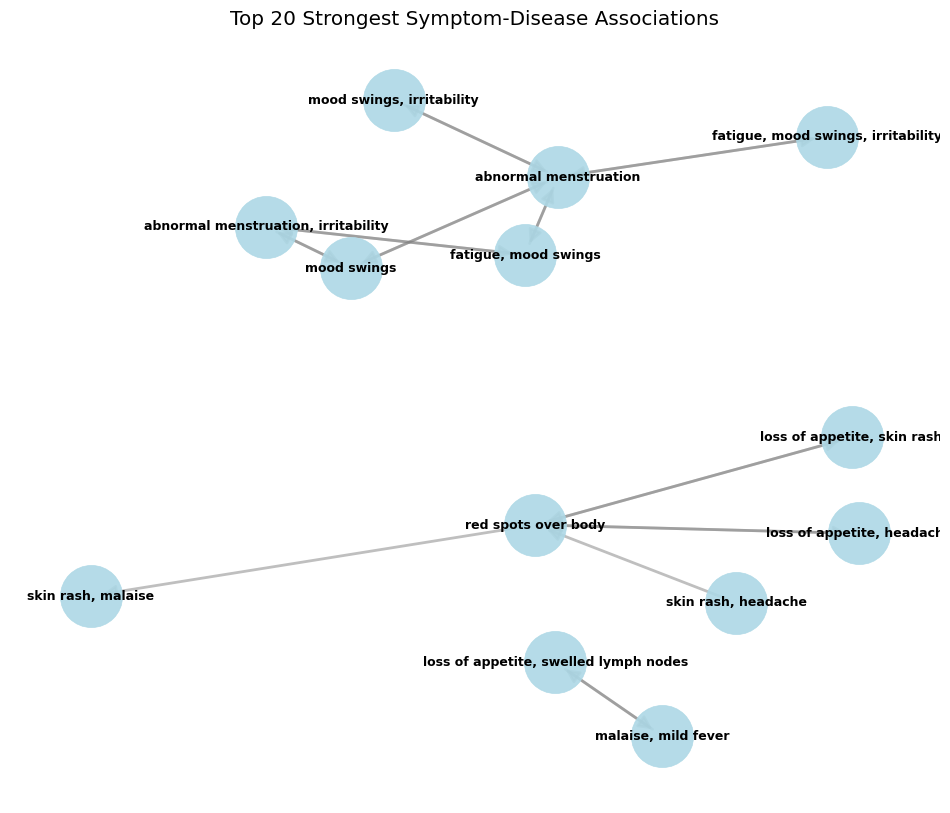

In [6]:
# Create a directed graph
G = nx.DiGraph()

# Add edges from the top 20 strongest rules
for i, row in strong_rules.head(20).iterrows():
    # Convert frozensets to strings
    antes = ', '.join(list(row['antecedents']))
    conse = ', '.join(list(row['consequents']))
    
    # Add edge with Lift as weight
    G.add_edge(antes, conse, weight=row['lift'])

# Draw the graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=1.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='gray', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

plt.title("Top 20 Strongest Symptom-Disease Associations")
plt.axis('off')

# Save the plot
plt.savefig('../results/network_graph.png', dpi=300, bbox_inches='tight')
print("✅ Network graph saved to '../results/network_graph.png'")
plt.show()

## 5. Visualization 3: Heatmap

✅ Heatmap saved to '../results/heatmap.png'


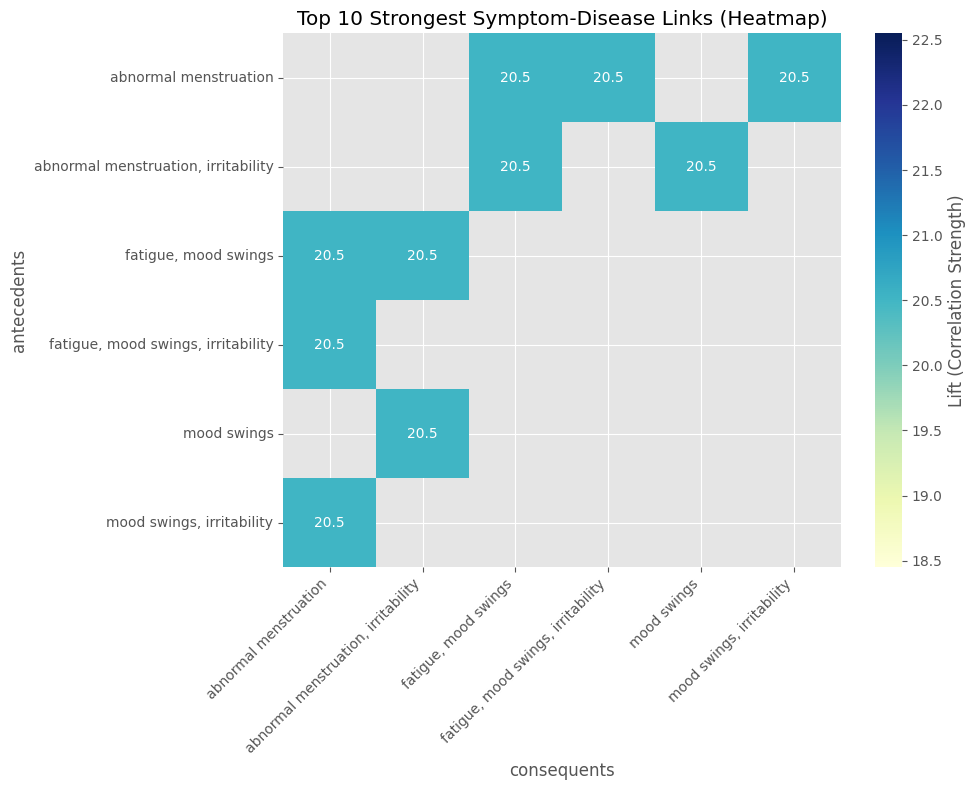

In [7]:
# Visualization 3: Heatmap (Top 10 Rules)

# We convert frozen sets to strings for the plot labels
heatmap_data = strong_rules.head(10).copy()
heatmap_data['antecedents'] = heatmap_data['antecedents'].apply(lambda x: ', '.join(list(x)))
heatmap_data['consequents'] = heatmap_data['consequents'].apply(lambda x: ', '.join(list(x)))

# Pivot the data to create a matrix: Antecedents on Y-axis, Consequents on X-axis, Lift as Color
heatmap_matrix = heatmap_data.pivot(index='antecedents', columns='consequents', values='lift')

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_matrix, 
    annot=True,     # Show the Lift values in the box
    fmt=".1f",      # Format numbers (e.g., 20.5)
    cmap="YlGnBu",  # Color scheme (Yellow to Blue)
    cbar_kws={'label': 'Lift (Correlation Strength)'}
)
plt.title("Top 10 Strongest Symptom-Disease Links (Heatmap)")
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('../results/heatmap.png')
print("✅ Heatmap saved to '../results/heatmap.png'")
plt.show()

## 6. Sensitivity Analysis 

In [8]:
analysis_data = {
    'Setting': ['Loose', 'Balanced', 'Strict'],
    'Min Support': ['0.01 (1%)', '0.03 (3%)', '0.10 (10%)'],
    'Min Confidence': ['0.5 (50%)', '0.7 (70%)', '0.9 (90%)'],
    'Lift Threshold': ['> 1.2', '> 2.0', '> 3.0'],
    'Total Rules': ['20,047', '2,685', '0'],
    'Interpretation': ['Rule Explosion (Too much noise)', 'Optimal (High quality)', 'Too Strict (No patterns)']
}

df_analysis = pd.DataFrame(analysis_data)
df_analysis.to_csv('../results/sensitivity_analysis.csv', index=False)
print("✅ Sensitivity Analysis saved to '../results/sensitivity_analysis.csv'")

✅ Sensitivity Analysis saved to '../results/sensitivity_analysis.csv'
